In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)
from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

#### 0. 데이터 불러오기
- stepwise로 선택된 변수
- 이상치가 대체된 배출량 data

In [2]:
data = pd.read_csv("행정동1 군집1번의 data 이상치 3.csv")
variable_dummy = np.load("행정동1 label 1 VIF10 선택변수.npy")
print(len(variable_dummy))
data.shape

27


(5108, 323)

성능평가 방법
- RMSLE

In [3]:
variable_dummy

array(['월_일배출량편차', '일강수량', '월배출량비율', '연휴전날', '월_일별결제건수비율', '일표준편차',
       '장기3거주표준편차', '장기2일편차', '연휴다음날', '내국인_행태별 0 부분패키지', '고용률',
       '내국인_목적별 0 친지방문', '월_10', '일강수량월편차', '월별예상승객편차', '월_1', 'PM10',
       '확진자수', '내국인_행태별 0 패키지', '요일부페결제건수비율', '일_25', '연_월양식결제금액비율',
       '장기2방문표준편차', '요일간식결제금액비율', '요일_수', '연배출금액편차', '일별예상승객편차'],
      dtype='<U15')

In [4]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def eval_reg(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:,.3f}".format(rmsle_val,rmse_val,mae_val))
    return rmsle_val,rmse_val,mae_val

#### 1. 데이터 생성하기
- 로그변환

In [5]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data["내국인_행태별 0 부분패키지"] = std.fit_transform(data["내국인_행태별 0 부분패키지"].values.reshape(-1,1))
std = StandardScaler()
data["내국인_행태별 0 패키지"] = std.fit_transform(data["내국인_행태별 0 패키지"].values.reshape(-1,1))
std = StandardScaler()
data["내국인_목적별 0 친지방문"] = std.fit_transform(data["내국인_목적별 0 친지방문"].values.reshape(-1,1))

In [6]:
Y = data["배출량"]
    
dummy = pd.get_dummies(data[["년","월","일","요일","분기"]],columns = ["년","월","일","요일","분기"]).columns
variable_nodummy = list(set(variable_dummy).difference(dummy))
# stepwise로 선택된 변수 중 dummy가 아닌 것들
    
select_dummy = list(set(variable_dummy).difference(variable_nodummy))
# stepwsie로 선택된 변수 중 dummy인 변수들
    
X_1 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[variable_nodummy]
# X_1 : 더미변수를 제하고 stepwise로 선택된 모든 변수 dataframe

X_2 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[select_dummy]
# X_2 : stepwise로 선택된 모든 더미변수 dataframe

loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in list(X_1.columns):
    if abs(X_1[val].skew())>3:
        X_1[val] = np.log1p(X_1[val])
        loglist.append(val)
        
X_1 = pd.DataFrame(X_1)
    
X_3 = data["행정동명"]
# Categorical Features인 행정동명
    
X = pd.concat([X_1,X_2,X_3],axis=1)
# X1, X2, X3 데이터 concat

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

reg = setup(data=train,
                target='배출량',
                numeric_imputation = 'mean',
                normalize = True,
                normalize_method = 'zscore',
                categorical_features = ["행정동명"],
                silent= True,
                fold_strategy = 'timeseries',
                fold = 3,
                session_id = 0,
                verbose=False)
print(loglist)

['연휴전날', '확진자수', 'PM10', '연휴다음날', '일강수량']


단일 모델 선택하기 위한 성능 비교

In [7]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,498306.2929,494061019109.9517,699021.6324,0.8023,0.1121,0.0784,0.5000
gbr,Gradient Boosting Regressor,498393.4768,482691144283.8121,691839.3731,0.8056,0.1129,0.0793,0.3500
et,Extra Trees Regressor,505727.2860,521999927318.6799,721368.5222,0.7889,0.1179,0.0805,0.3767
ridge,Ridge Regression,557102.6458,565882978304.0000,752005.3542,0.7696,0.1200,0.0876,1.1300
lr,Linear Regression,557500.8333,567083302912.0000,752800.3542,0.7691,0.1202,0.0876,1.8767
lasso,Lasso Regression,557499.8333,567081555285.3334,752799.2292,0.7691,0.1202,0.0876,1.4600
llar,Lasso Least Angle Regression,557467.3500,567040647411.6874,752771.8664,0.7691,0.1202,0.0876,0.0133
rf,Random Forest Regressor,526351.3749,551419607342.8481,740565.6101,0.7776,0.1206,0.0838,0.5800
huber,Huber Regressor,572563.8871,618030694019.5999,785520.4140,0.7491,0.1240,0.0899,0.0333
lar,Least Angle Regression,579109.2676,615805106439.9772,784319.7352,0.7493,0.1242,0.0905,0.0167


[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_s

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- RMSLE을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정

In [8]:
tuned_models = []

In [9]:
### 상위 모델 1번 : Extra Tree Regressor
model_01 = create_model("et")

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,549324.2686,620764745648.4651,787886.2517,0.7740,0.1310,0.0893
1,502249.0335,467917067904.6935,684044.6388,0.8098,0.1069,0.0771
2,516050.2353,546139841786.7516,739012.7481,0.7541,0.1196,0.0819
Mean,522541.1791,544940551779.9700,736981.2129,0.7793,0.1191,0.0828
SD,19758.8580,62405565298.3302,42417.4924,0.0230,0.0098,0.0050


In [10]:
### 상위 모델 2번 : Extra Tree Regressor
model_02 = create_model("gbr")

model_02 = tune_model(model_02, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,533777.3494,582700991767.1808,763348.5389,0.7878,0.1280,0.0869
1,466244.7117,411574140157.8538,641540.4431,0.8327,0.0980,0.0706
2,459186.6358,408689729087.7328,639288.4553,0.8160,0.1037,0.0727
Mean,486402.8990,467654953670.9225,681392.4791,0.8122,0.1099,0.0767
SD,33622.4927,81358355924.2264,57958.9778,0.0185,0.0130,0.0073


In [11]:
#  Light Gradient Boosting Machine 튜닝 (상위 모델 3번)
model_03 = create_model('lightgbm')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,531969.4999,563974366812.4993,750982.2680,0.7946,0.1260,0.0864
1,468663.7214,417460658015.9994,646111.9547,0.8303,0.0971,0.0707
2,451854.0849,414389178623.5387,643730.6724,0.8135,0.1065,0.0727
Mean,484162.4354,465274734484.0125,680274.9650,0.8128,0.1099,0.0766
SD,34494.2269,69802442950.3172,50007.0638,0.0146,0.0121,0.0070


배깅

In [12]:
prediction_models = []

bag_01_15 = ensemble_model(model_01 , n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_01_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,539953.0142,606118347281.3813,778536.0282,0.7793,0.1297,0.0879
1,486817.0747,444850032939.9806,666970.7887,0.8192,0.1048,0.0748
2,487234.5130,498267805404.4219,705880.8720,0.7757,0.1161,0.0780
Mean,504668.2006,516412061875.2612,717129.2296,0.7914,0.1169,0.0802
SD,24950.7130,67075966062.3133,46235.5911,0.0197,0.0102,0.0056


In [13]:
bag_02_15 = ensemble_model(model_02, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_02_15 )


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,518686.7915,554427827762.1200,744599.1054,0.7981,0.1239,0.0841
1,458344.7461,388792545492.9082,623532.3131,0.8420,0.0956,0.0693
2,451630.7964,416638235078.4906,645475.2010,0.8124,0.1067,0.0726
Mean,476220.7780,453286202777.8396,671202.2065,0.8175,0.1087,0.0753
SD,30152.8441,72415775608.4946,52666.8850,0.0183,0.0117,0.0063


In [14]:
bag_03_15 = ensemble_model(model_03, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,516829.6058,558258998545.0610,747167.3163,0.7967,0.1252,0.0842
1,455693.5427,389152093316.0260,623820.5618,0.8418,0.0955,0.0691
2,442927.7457,405718551435.0473,636960.4002,0.8174,0.1059,0.0714
Mean,471816.9648,451043214432.0449,669316.0928,0.8186,0.1089,0.0749
SD,32252.5946,76114081727.7110,55309.8761,0.0184,0.0123,0.0067


부스팅

In [15]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,538207.4960,596500346880.2759,772334.3492,0.7828,0.1291,0.0878
1,492945.5993,449253739588.7856,670263.9328,0.8174,0.1039,0.0752
2,489134.5817,489705810763.4636,699789.8333,0.7795,0.1149,0.0781
Mean,506762.5590,511819965744.1750,714129.3717,0.7933,0.1160,0.0803
SD,22289.2951,62113700730.1759,42885.9670,0.0171,0.0103,0.0054


In [16]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,537449.8406,585201615922.5166,764984.7161,0.7869,0.1280,0.0875
1,486648.3741,432247324280.5268,657455.1880,0.8243,0.1000,0.0734
2,463319.2380,426422742665.5520,653010.5226,0.8080,0.1072,0.0740
Mean,495805.8175,481290560956.1984,691816.8089,0.8064,0.1117,0.0783
SD,30948.6741,73514678561.0750,51769.3329,0.0153,0.0118,0.0065


In [17]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,544275.4779,588994426229.7080,767459.7229,0.7855,0.1281,0.0883
1,466719.8346,400152816358.1034,632576.3324,0.8374,0.0957,0.0703
2,448306.2393,402184901393.7496,634180.4959,0.8189,0.1040,0.0716
Mean,486433.8506,463777381327.1870,678072.1837,0.8140,0.1093,0.0767
SD,41585.2980,88545707944.1196,63209.9277,0.0215,0.0137,0.0082


블렌딩

In [18]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='RMSLE')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,510099.0864,541866760027.5412,736115.9963,0.8027,0.1246,0.0836
1,456461.5321,394974861086.6737,628470.2547,0.8395,0.0964,0.0693
2,445579.4657,408863868184.2624,639424.6384,0.8159,0.1057,0.0714
Mean,470713.3614,448568496432.8258,668003.6298,0.8194,0.1089,0.0747
SD,28202.0252,66215056806.7464,48369.8975,0.0152,0.0118,0.0063


#### 생성된 모델에 대한 Train 데이터에 대한 성과 확인

In [19]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,481917.4796,479442735219.6633,692418.0350,0.8113,0.1118,0.0762


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7718955.09
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6539169.00
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6080110.50
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7776436.00
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9166195.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6380398.50
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,3964129.63
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,8003743.00
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8205658.00


GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,444979.1913,402879886927.3764,634728.1993,0.8414,0.1017,0.0698


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.728611e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.890633e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,5.791380e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,8.028711e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.526921e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.353878e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,3.941976e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.607732e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.502889e+06


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,426410.8445,359363289805.9032,599469.1734,0.8585,0.0960,0.0665


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.569329e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.683382e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,5.955190e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.405733e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.422988e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.227067e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.469553e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.892100e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.068552e+06


In [20]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,476905.4261,468291369731.4103,684318.1787,0.8157,0.1103,0.0754


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.632684e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.728231e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6.145892e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.812470e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.357373e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.397187e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.113738e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.951766e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.150803e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,439378.4015,391978458117.8229,626081.8302,0.8457,0.1009,0.0690


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.530074e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.918638e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,5.924463e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.786575e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.379027e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.325360e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.107075e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.809835e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,7.981148e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,424190.1677,363541177812.5673,602943.7601,0.8569,0.0971,0.0666


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.490701e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.836524e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6.025562e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.641521e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.239058e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.275395e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.312840e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.757434e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,7.931917e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,480406.4405,467344257823.3207,683625.8171,0.8160,0.1105,0.0760


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.550978e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.665071e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6.095729e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.765362e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.417117e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.386108e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.144191e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.883228e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.262074e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,448760.5519,401193430837.9366,633398.3193,0.8421,0.1032,0.0707


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.546401e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.926860e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6.087463e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.567134e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.463753e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.437142e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.066811e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.874902e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.327353e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,433121.7061,370621273703.9820,608786.7227,0.8541,0.0980,0.0679


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.419377e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.857773e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,6.074097e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.534916e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.015697e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.187032e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.211599e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.805024e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,7.921531e+06


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,431778.7925,379384525934.2720,615941.9826,0.8507,0.0996,0.0680


,내국인_행태별 0 패키지,요일부페결제건수비율,연배출금액편차,장기3거주표준편차,연_월양식결제금액비율,내국인_행태별 0 부분패키지,장기2방문표준편차,월_일배출량편차,고용률,월_일별결제건수비율,...,월_10,요일_수,연휴전날_0.6931471824645996,연휴다음날_0.0,행정동명_노형동,행정동명_연동,행정동명_이도2동,행정동명_일도2동,배출량,Label
0,-0.845026,-0.971602,0.440624,2.340741,-0.568900,-1.102950,1.433735,0.976914,-1.936958,0.867934,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,6773150.0,7.672298e+06
1,0.623083,0.098585,-0.277487,-0.394586,0.711466,1.206201,-0.572919,-0.726294,0.170053,-0.708751,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,6883750.0,6.704395e+06
2,-0.714584,0.319249,-0.579442,0.220444,0.777352,-0.851737,3.205191,-0.471871,1.269369,-1.559476,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,6080050.0,5.942227e+06
3,0.583451,0.999781,-0.168306,-0.588575,0.571690,0.235067,-0.636766,-0.142892,0.628100,-1.263742,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,8241750.0,7.736960e+06
4,0.081125,-0.174135,0.334875,0.570329,0.563593,-0.018111,-0.622057,3.130836,0.628100,-0.686233,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,11340650.0,9.372035e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,-0.301960,2.529255,-0.401147,-1.054482,0.587213,-0.103308,-1.049431,-0.321762,0.170053,-0.545448,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,6568950.0,6.320448e+06
1222,-0.845510,-1.851278,-0.635415,-0.844003,-1.873045,-0.881609,-0.709056,-1.084124,-3.036274,-0.432973,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,4519650.0,4.125219e+06
1223,0.583451,0.538847,-0.168306,-0.548131,0.571690,0.235067,-0.636096,-0.321684,0.628100,-1.274889,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,7363000.0,7.834525e+06
1224,-0.722039,-1.021003,0.440624,1.249966,-1.960788,-1.050312,0.493422,1.264325,-0.746041,-1.687211,...,0,0,0.0,1.0,1.0,0.0,0.0,0.0,8372300.0,8.259033e+06


#### 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [21]:
final_01 = finalize_model(model_03) # 성능 상위모델 1번: 단일모델 gbr
final_02 = finalize_model(boo_03) # 성능 상위모델 2번: 부스팅 gbr
final_03  = finalize_model(blend_3_soft) # 성능 상위모델 3번: 부스팅 lgbm

In [22]:
from sklearn.metrics import r2_score
value_list = [] # test를 통해 상위 3개의 모델에 대한 mse / r2값 확인 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    rmsle_score = rmsle(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("rmsle 값: {} // r2_score: {}".format(rmsle_score, r2score))


rmsle 값: 0.08753073506858103 // r2_score: 0.8910285121064558
rmsle 값: 0.08732305270892492 // r2_score: 0.8865596689158224
rmsle 값: 0.09020492739483353 // r2_score: 0.8818785602475723


In [ ]:
from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

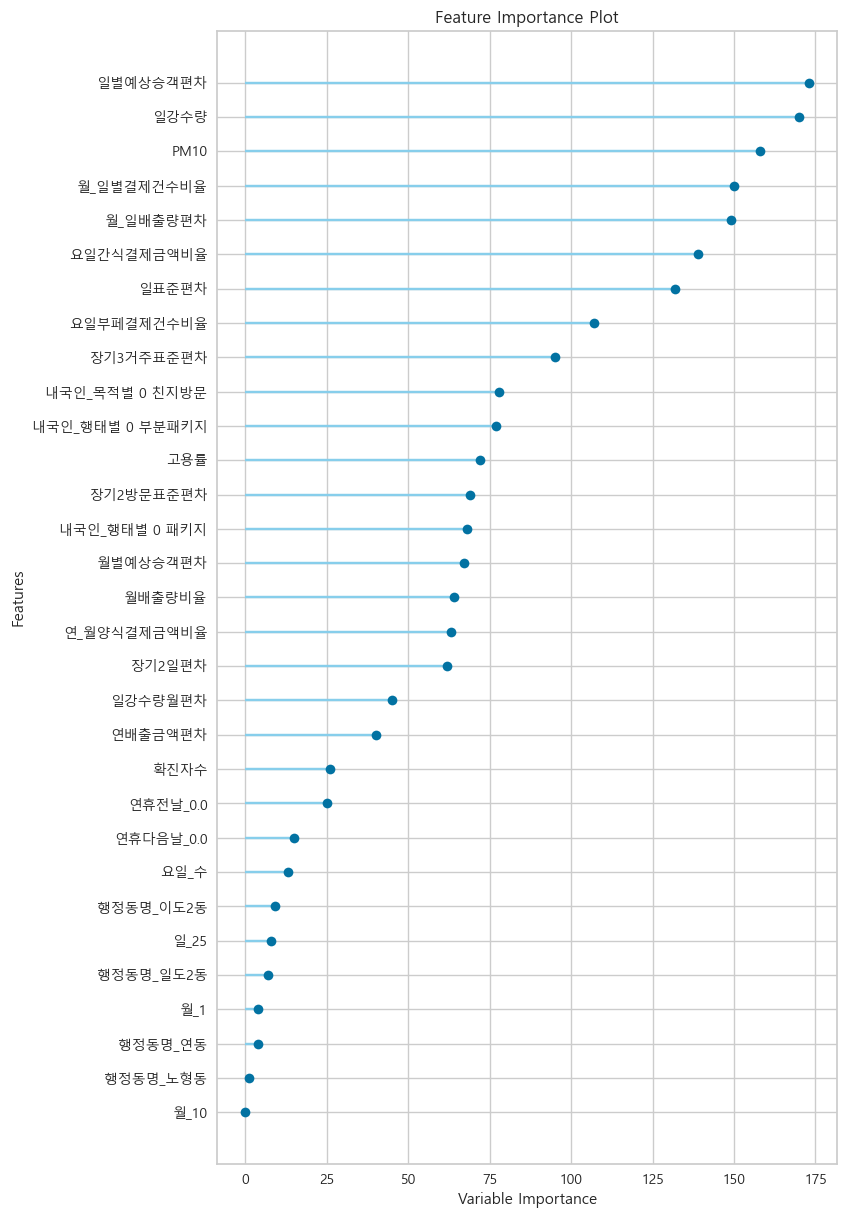

In [25]:
# 피쳐 중요도 확인
plot_model(final_01, 'feature_all' )

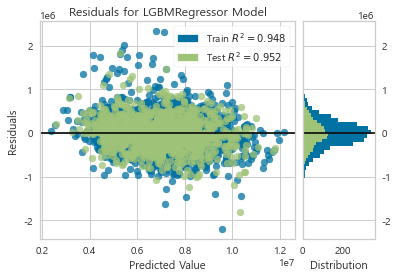

In [27]:


# 피쳐 중요도 확인
plot_model(final_01,"residuals" )

In [23]:
# q-q-plot
plot_model(final_01,"residuals_interactive")

    'data': [{'hovertemplate': 'Split=train<br>Predictions…